In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
try:
    import seaborn as sns
    sns.set_style('ticks')
    sns.set_context('talk', font_scale=1.5)
    sns.set_palette('colorblind')
except ImportError:
    print("Install seaborn for plot aesthetics")
    plt.style.use('fivethirtyeight')

# Fixation probability

## Pure Python

In [43]:
import random

def simulation(N, s):
    n1 = 1

    while 0 < n1 < N:
        n0 = N - n1
        p1 = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = sum(
            1 
            for _ in range(N) 
            if random.random() < p1
        )              

    return n1 == N

print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [44]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

100 loops, best of 3: 8.13 ms per loop
1 loop, best of 3: 319 ms per loop


## NumPy

In [91]:
import numpy as np

In [92]:
def simulation(N, s):
    n1 = 1

    while 0 < n1 < N:
        n0 = N - n1
        p1 = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = np.random.binomial(N, p1)        

    return n1 == N

print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [93]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10000 loops, best of 3: 161 µs per loop
1000 loops, best of 3: 337 µs per loop


## Cython

In [94]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [103]:
%%cython
import numpy as np
cimport numpy as np

def simulation(np.uint64_t N, np.float64_t s):
    cdef np.uint64_t n1 = 1
    cdef np.uint64_t n0    
    cdef np.float64_t p
    
    while 0 < n1 < N:
        n0 = N - n1
        p1 = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = np.random.binomial(N, p1)               

    return n1 == N

In [104]:
print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [105]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

The slowest run took 7.83 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 99.1 µs per loop
The slowest run took 5.28 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 224 µs per loop


## Numba

In [106]:
import numba
print("Numba", numba.__version__)

Numba 0.25.0


In [107]:
@numba.jit(locals=dict(s=numba.float64, N=numba.uint64, n0=numba.uint64, n1=numba.uint64, p=numba.float64))
def simulation(N, s):
    n1 = 1

    while N > n1 > 0:
        n0 = N - n1
        p = n1 * (1 + s) / (n0 + n1 * (1 + s))
        n1 = np.random.binomial(N, p)        

    return n1 == N

print("Fixate?", simulation(N=1000, s=0.1))

Fixate? False


In [109]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10000 loops, best of 3: 57.9 µs per loop
100 loops, best of 3: 33.8 ms per loop


# Multiple simulations

## Pure Python

In [116]:
import random

def one_simulation(N, s):
    n1 = 1

    while N > n1 > 0:
        p = n1 * (1 + s) / (N + n1 * s)
        n1 = sum(1 for _ in range(N) if random.random() < p)              

    return n1 == N

def simulation(N, s, repetitions=1000):
    return [one_simulation(N, s) for _ in range(repetitions)]

fixations = simulation(N=1000, s=0.1, repetitions=1000)
print("Fixate %", sum(fixations)/len(fixations))

Fixate % 0.178


In [113]:
%timeit simulation(N=1000, s=0.1)


1 loop, best of 3: 8.05 s per loop


## NumPy

In [118]:
def simulation(N, s, repetitions=1000):
    n1 = np.ones(repetitions, dtype=np.uint64)
    update = (n1 > 0) & (n1 < N)
    
    while update.any():
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        update = (n1 > 0) & (n1 < N)

    return n1 == N

print("Fixate %", simulation(N=1000, s=0.1).mean())

Fixate % 0.187


In [17]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10 loops, best of 3: 39.2 ms per loop
1 loop, best of 3: 395 ms per loop


## Cython

In [52]:
%%cython
cimport cython
import numpy as np
cimport numpy as np

def simulation(np.uint64_t N, np.float64_t s, np.uint32_t repetitions=1000):
    cdef np.ndarray[np.uint64_t] n1 = np.ones(repetitions, dtype=np.uint64)
    cdef np.ndarray[np.uint8_t, cast=True] update = (n1 > 0) & (n1 < N)
    cdef np.ndarray[np.float64_t] p
    
    while update.any():
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        update = (n1 > 0) & (n1 < N)

    return n1 == N

In [19]:
print("Fixate %", simulation(N=1000, s=0.1).mean())

Fixate % 0.186


In [20]:
%timeit simulation(N=1000, s=0.1)
%timeit simulation(N=1000000, s=0.01)

10 loops, best of 3: 43 ms per loop
1 loop, best of 3: 417 ms per loop


## Fixation probability as function of population size

Kimura's equation:

$$
\frac{1 - e^{-2s}}{1 - e^{-2Ns}}
$$

For large $N$, the denominator is roughly 1, and if $s$ is small than we can approximate this by $2s$. 

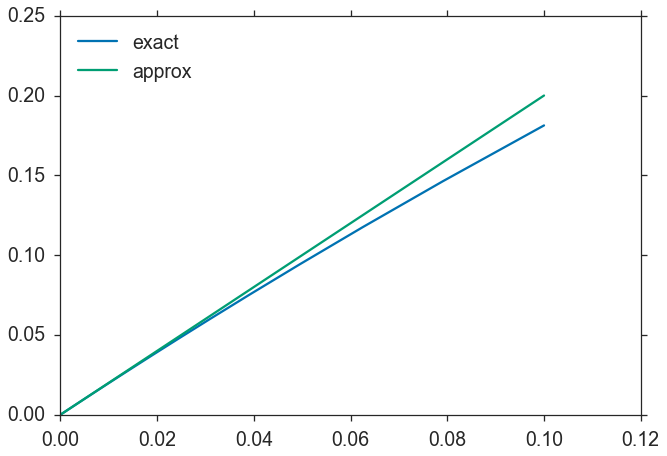

In [21]:
srange = np.logspace(-6, -1)
plt.plot(srange, 1 - np.exp(-2 * srange), label='exact')
plt.plot(srange, 2 * srange, label='approx')
plt.legend(loc=2)

In [22]:
def kimura(N, s):
    return np.expm1(-2 * s) / np.expm1(-2 * N * s)

In [25]:
Nrange_kimura = np.logspace(1, 6, 50000, dtype=np.int64)
s = 0.1

In [26]:
%timeit [kimura(N=N, s=s) for N in Nrange_kimura]
%timeit -n 1000 kimura(N=Nrange_kimura, s=s)

1 loop, best of 3: 917 ms per loop
1000 loops, best of 3: 4.77 ms per loop


## Numexpr

https://github.com/pydata/numexpr/wiki/Numexpr-Users-Guide

In [27]:
import numexpr as ne
print("Numexpr", ne.__version__)
print(ne.get_vml_version())

Numexpr 2.5.2
Intel(R) Math Kernel Library Version 11.3.1 Product Build 20151021 for Intel(R) 64 architecture applications


In [28]:
def kimura(N, s):
    return ne.evaluate("expm1(-2 * s) / expm1(-2 * N * s)")

In [29]:
%timeit -n 1000 kimura(N=Nrange_kimura, s=s)

1000 loops, best of 3: 1.18 ms per loop


## Plot

In [134]:
Nrange_kimura = np.logspace(1, 6, 500)
fix_prob_kimura = kimura(N=Nrange_kimura, s=s)

In [128]:
repetitions = 1000
s = 0.01
Nrange = np.logspace(1, 6, 20, dtype=np.uint64)

In [131]:
%%timeit
fix_prob_sim = np.array([
    simulation(N=N, s=s, repetitions=repetitions)
    for N in Nrange
])

1 loop, best of 3: 4.37 s per loop


In [129]:
fix_prob_sim = np.array([
    simulation(N=N, s=s, repetitions=repetitions)
    for N in Nrange
])

fix_prob_sim_mean = fix_prob_sim.mean(axis=1)
fix_prob_sim_sem = fix_prob_sim.std(axis=1, ddof=1) / np.sqrt(repetitions)

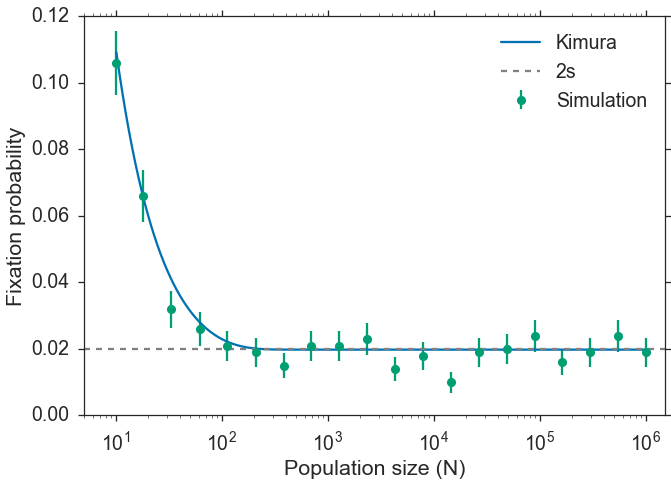

In [135]:
fig, ax = plt.subplots(1, 1)

ax.plot(Nrange_kimura, fix_prob_kimura, ls='-', label='Kimura')
ax.axhline(2*s, color='gray', ls='--', label='2s')
ax.errorbar(x=Nrange, y=fix_prob_sim_mean, yerr=fix_prob_sim_sem, 
            fmt='o', capsize=5, label='Simulation')


ax.set(
    xlabel='Population size (N)',
    ylabel='Fixation probability',
    xscale='log', 
    xlim=(0.5 * Nrange.min(), 1.5 * Nrange.max()),
)
ax.legend();

# Fixation time

In [56]:
def simulation(N, s, repetitions=1000):
    N = int(N) # very important! if this is a float than the while loop will be ~infinite
    n1 = np.ones(repetitions, dtype=np.uint64)
    T = np.empty_like(n1)
    update = (n1 > 0) & (n1 < N)
    t = 0
    
    while update.any():
        t += 1
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        T[update] = t
        update = (n1 > 0) & (n1 < N)

    return n1 == N, T

print("Fixate %", simulation(N=1000, s=0.1)[0].mean())

Fixate % 0.181


In [57]:
%timeit simulation(N=10, s=0.01, repetitions=1000)
%timeit simulation(N=1000000, s=0.01, repetitions=1000)

100 loops, best of 3: 11.8 ms per loop
1 loop, best of 3: 418 ms per loop


In [58]:
fixations, times = simulation(N=10000, s=0.1, repetitions=1000)
fixation_prob = fixations.mean()
fixation_time = times[fixations].mean()
print("% Fixation: {:.2g}".format(fixation_prob))
print("Avg. time: {:.0f}".format(fixation_time))

% Fixation: 0.18
Avg. time: 168


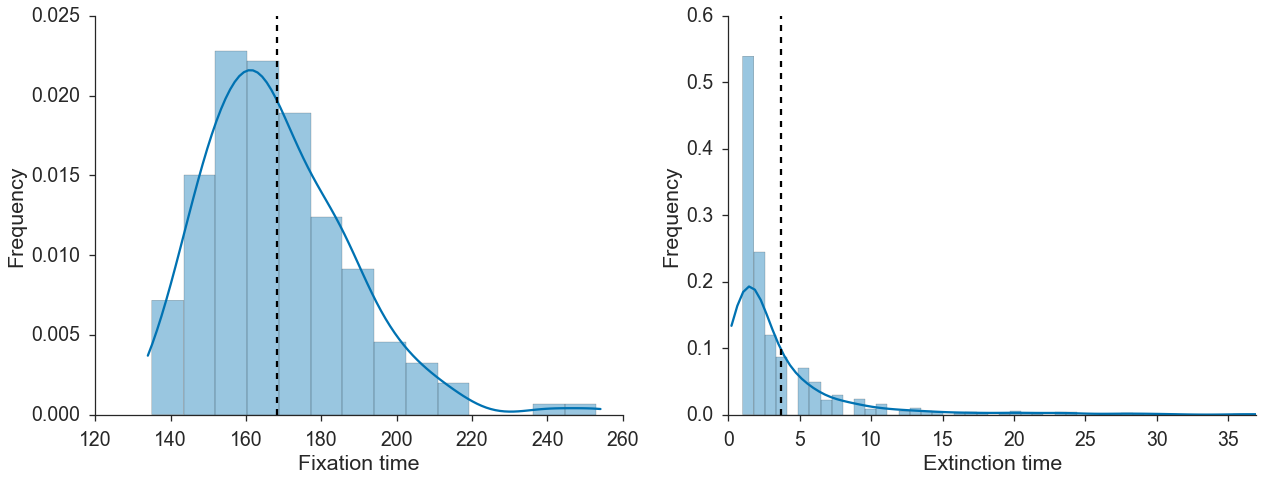

In [59]:
w, h = plt.rcParams['figure.figsize']
fig, ax = plt.subplots(1, 2, figsize=(2 * w, h))

sns.distplot(times[fixations], ax=ax[0])
ax[0].axvline(times[fixations].mean(), color='k', ls='--')
ax[0].set(xlabel='Fixation time', ylabel='Frequency')

sns.distplot(times[~fixations], ax=ax[1])
ax[1].axvline(times[~fixations].mean(), color='k', ls='--')
ax[1].set(xlabel='Extinction time', ylabel='Frequency', 
          xlim=(0, times[~fixations].mean()*10))
sns.despine()

In [60]:
%%cython
cimport cython
import numpy as np
cimport numpy as np

def simulation(np.uint64_t N, np.float64_t s, np.uint32_t repetitions=1000):
    cdef np.ndarray[np.uint64_t] n1 = np.ones(repetitions, dtype=np.uint64)
    cdef np.ndarray[np.uint64_t] T = np.empty_like(n1)
    cdef np.ndarray[np.uint8_t, cast=True] update = (n1 > 0) & (n1 < N)
    cdef np.ndarray[np.float64_t] p
    cdef np.uint64_t t = 0
    
    while update.any():
        t += 1
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        T[update] = t
        update = (n1 > 0) & (n1 < N)

    return n1 == N, T

In [61]:
%timeit simulation(N=10, s=0.01, repetitions=1000)
%timeit simulation(N=1000000, s=0.01, repetitions=1000)

100 loops, best of 3: 12.6 ms per loop
1 loop, best of 3: 443 ms per loop


## Fixation time as function of population size

In [62]:
repetitions = 1000
s = 0.1
Nrange = np.logspace(1, 6, 10, dtype=np.uint64)

def fix_time_simulation(N):
    fixations, times = simulation(N=N, s=s, repetitions=repetitions)
    fixation_time_mean = times[fixations].mean()
    fixation_time_std =  times[fixations].std(ddof=1) / np.sqrt(repetitions)
    return fixation_time_mean, fixation_time_std

fix_time_sim = np.array([
    fix_time_simulation(N=N)
    for N in Nrange
])

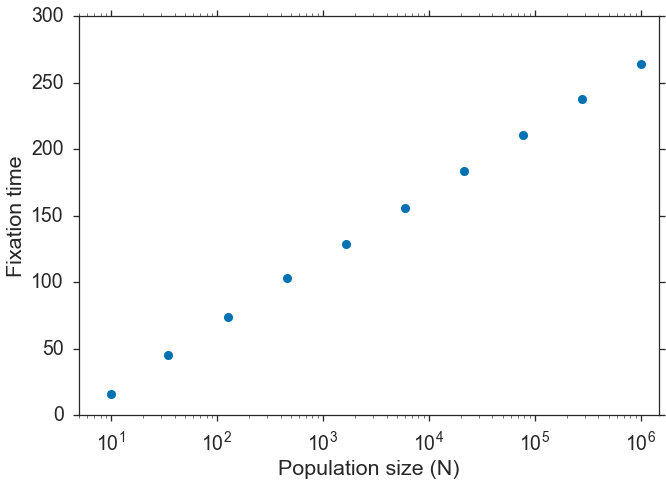

In [63]:
def fixation_time_plot(N, mean, sem):
    fig, ax = plt.subplots(1, 1)

    ax.errorbar(x=N, y=mean, yerr=sem, 
                fmt='o', capsize=5, label='Simulation')

    ax.set(
        xlabel='Population size (N)',
        ylabel='Fixation time',
        xscale='log', 
        xlim=(0.5 * Nrange.min(), 1.5 * Nrange.max()),
    )
    return fig, ax

fixation_time_plot(Nrange, fix_time_sim[:,0], fix_time_sim[:,1]);

## Fixation time approximations

### Deterministic approximation

The first approximation is attributed to [Haldane 1924](http://link.springer.com/article/10.1007%2FBF02459574) (via [Hartfiled & Otto 2011](http://www.ncbi.nlm.nih.gov/pubmed/21884046)).

The frequency of the mutant can be approximated by: 

$$
f(t) = \frac{f(0)}{f(0) + (1-f(0))(1-s)^t}
$$
or assuming $f(0)=1/N$ and $N-1 \approx N$:
$$
f(t) = \frac{1}{1 + N (1-s)^t}
$$

Inversing this equation and looking for time $T_{fix}$ in which $f(T_{fix})=\frac{N-1}{N}$ we get:
$$
T_{fix} = -2 \frac{\log{N}}{\log{(1-s)}}
$$

In [64]:
def T_haldane(N, s):
    return -2 * np.log(N) / np.log1p(-s)
%timeit T_haldane(np.logspace(2, 9, 100000), 0.01)
def T_haldane(N, s):
    return ne.evaluate("-2 * log(N) / log1p(-s)")
%timeit T_haldane(np.logspace(2, 9, 100000), 0.01)

100 loops, best of 3: 14.9 ms per loop
100 loops, best of 3: 12.4 ms per loop


### Stochastic approximation

A more complex approximation is based on a *diffusion equation* and is taken from eq. (17) in [Kimura and Ohta 1969](http://www.pubmedcentral.nih.gov/articlerender.fcgi?artid=1212239) (the reference assumes a population size of $2N$ gametes and selection advantage of $s/2$ rather then $N$ and $s$, therefore I'm changing $s=2s$ and $N=N/2$).

$$
I_1(x) = \frac{1 - e^{-2Nsx} - e^{-2Ns(1-x)} + e^{-2Ns}}{x(1-x)} \\
I_2(x) = \frac{(e^{2Nsx} - 1) (1 - e^{-2Ns(1-x)})}{x(1-x)} \\
J_1 = \frac{1}{s(1-e^{-2Ns})} \int_{x}^{1}{I_1(y) dy} \\
J_2 = \frac{1}{s(1-e^{-2Ns})} \int_{0}^{x}{I_2(y) dt} \\
u = \frac{1 - e^{-2Nsx}}{1 - e^{-2Ns}} \\
T_{fix} = J1 + \frac{1-u}{u} J_2
$$

Here we need to integrate some functions, we'll do this using `scipy.integrate.quad`. 

In [65]:
from scipy.integrate import quad as integral

In [66]:
def integrand1(N, s, x):
    if x == 1:
        return 0
    return (1 - np.exp(-2*N*s*x) - np.exp(-2 * N * s * (1 - x)) + np.exp(-2 * N *s)) / (x*(1-x))

def integrand2(N, s, x):
    if x == 0:
        return 0
    return -np.expm1(2 * N * s * x) * np.expm1(-2 * N * s * x) / (x * (1 - x))

@np.vectorize
def T_kimura(N, s):
    x = 1.0 / N
    J1 = -1.0 / (s * np.expm1(-2 * N * s)) * integral(lambda y: integrand1(N, s, y), x, 1)[0]
    u = np.expm1(-2 * N * s * x) / np.expm1(-2 * N * s)
    J2 = -1.0 / (s * np.expm1(-2 * N *s)) * integral(lambda y: integrand2(N, s, y), 0, x)[0]
    return J1 + ((1 - u) / u) * J2

assert 254 < T_kimura(1e6, 0.1) < 255

In [67]:
Nrange_kimura = np.logspace(1, 6, 100)
%timeit x = np.array([T_kimura(N=N, s=s) for N in Nrange_kimura])
%timeit y = T_kimura(N=Nrange_kimura, s=s)

1 loop, best of 3: 1.84 s per loop
1 loop, best of 3: 868 ms per loop


In [68]:
def integrand1_ne(N, s, x):
    if x == 1:
        return 0    
    return ne.evaluate("(1 - exp(-2*N*s*x) - exp(-2 * N * s * (1 - x)) + exp(-2 * N *s)) / (x*(1-x))")

def integrand2_ne(N, s, x):
    if x == 0:
        return 0    
    return ne.evaluate("-expm1(2 * N * s * x) * expm1(-2 * N * s * x) / (x * (1 - x))")

@np.vectorize
def T_kimura_ne(N, s):
    x = ne.evaluate("1.0 / N")
    J1 = ne.evaluate("-1.0 / (s * expm1(-2 * N * s))") * integral(lambda y: integrand1(N, s, y), x, 1)[0]
    u = ne.evaluate("expm1(-2 * N * s * x) / expm1(-2 * N * s)")
    J2 = ne.evaluate("-1.0 / (s * expm1(-2 * N *s))") * integral(lambda y: integrand2(N, s, y), 0, x)[0]
    return ne.evaluate("J1 + ((1 - u) / u) * J2")

assert 254 < T_kimura(1e6, 0.1) < 255

In [69]:
%timeit y = T_kimura_ne(N=Nrange_kimura, s=s)

1 loop, best of 3: 912 ms per loop


In [70]:
Nrange_kimura = np.logspace(1, 8, 20)
fix_time_kimura = T_kimura(N=Nrange_kimura, s=s)
fix_time_haldane = T_haldane(N=Nrange_kimura, s=s)

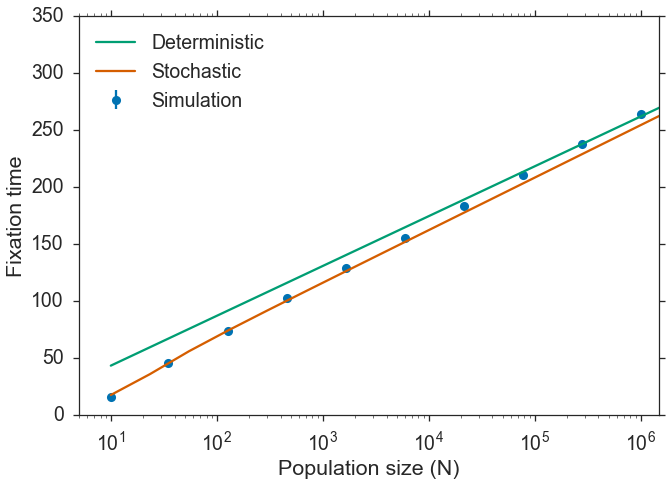

In [71]:
fig, ax = fixation_time_plot(Nrange, fix_time_sim[:,0], fix_time_sim[:,1]);
ax.plot(Nrange_kimura, fix_time_haldane, ls='-', label='Deterministic')
ax.plot(Nrange_kimura, fix_time_kimura, ls='-', label='Stochastic')
ax.legend(loc='upper left');

## SymPy

http://docs.sympy.org/latest/tutorial/basic_operations.html#evalf

In [72]:
import sympy as sp
sp.init_printing() # for notebook display
print("SymPy", sp.__version__)

SymPy 1.0


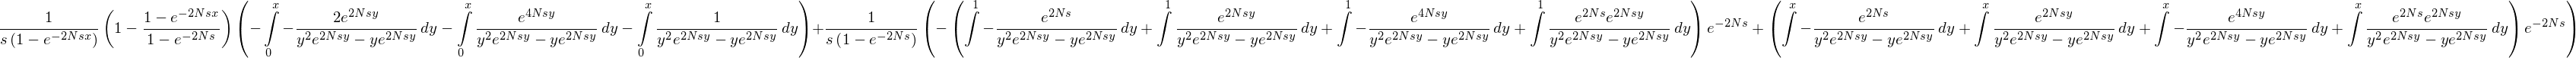

In [73]:
N, s, x, y = sp.symbols('N s x y')
I1 = (1 - sp.exp(-2*N*s*y) - sp.exp(-2*N*s*(1-y)) + sp.exp(-2*N*s)) / (y*(1-y))
I2 = (sp.exp(2*N*s*y) - 1) * (1 - sp.exp(-2*N*s*y))/(y*(1-y))
J1 = 1/(s*(1 - sp.exp(-2*N*s))) * sp.integrate(I1, (y, x, 1))
J2 = 1/(s*(1 - sp.exp(-2*N*s))) * sp.integrate(I2, (y, 0, x))
u = (1 - sp.exp(-2*N*s*x))/(1 - sp.exp(-2*N*s))
T = J1 + ((1 - u)/u) * J2
T

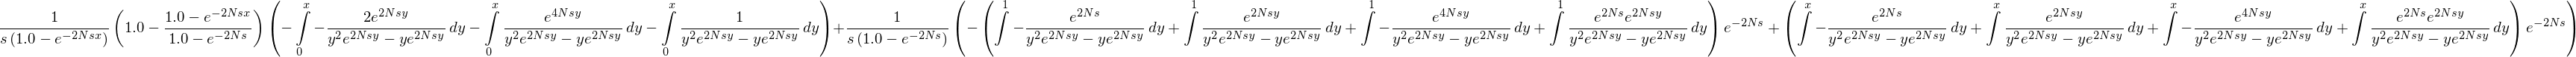

In [74]:
T.evalf(subs={x: 0.01, N: 100.0, s:0.01})

## Parallelization

http://ipyparallel.readthedocs.org/en/latest/multiengine.html

In [75]:
def simulation(N, s, repetitions=1000):
    import numpy as np # needed for parallel runs
    N = int(N)
    
    n1 = np.ones(repetitions, dtype=np.uint64)
    T = np.empty_like(n1)
    update = (n1 > 0) & (n1 < N)
    t = 0
    
    while update.any():
        t += 1
        p = n1 * (1 + s) / (N + n1 * s) 
        n1[update] = np.random.binomial(N, p[update])
        T[update] = t
        update = (n1 > 0) & (n1 < N)

    return n1 == N, T

print("Fixate %", simulation(N=1000, s=0.1)[0].mean())

Fixate % 0.171


In [76]:
%timeit simulation(N=1000000, s=0.01, repetitions=1000)

1 loop, best of 3: 616 ms per loop


In [77]:
def fix_time_aggregate(sim_results):
    fixations, times = sim_results
    fixation_time_mean = times[fixations].mean()
    fixation_time_sem =  times[fixations].std(ddof=1) / np.sqrt(repetitions)
    return fixation_time_mean, fixation_time_sem

fixation_time_mean, fixation_time_sem = fix_time_aggregate(simulation(N=1000000, s=0.01, repetitions=1000))
print("Mean time: {:.2f} +- {:.5f} (sem)".format(fixation_time_mean, fixation_time_sem))

Mean time: 2150.43 +- 5.61536 (sem)


In [78]:
import contextlib
import time

@contextlib.contextmanager
def tictoc():
    tic = time.time()
    yield tic
    toc = time.time()
    print("Elapsed: {:.4f} seconds".format(toc - tic))

In [79]:
repetitions = 1000
s = 0.01
Nrange = np.logspace(1, 6, 50)

with tictoc():
    fix_time_sim = [
        simulation(N=N, s=s, repetitions=repetitions)
        for N in Nrange
    ]

Elapsed: 14.3823 seconds


In [80]:
import ipyparallel
print("IPython Parallel", ipyparallel.__version__)
from ipyparallel import Client

IPython Parallel 5.0.1


```
>>> ipcluster start --n=4
```

In [81]:
rc = Client()
print("Engines IDs", rc.ids)
dview = rc[:] # use all engines

Engines IDs [0]


In [82]:
with tictoc():
    fix_time_sim = dview.map_sync(
        simulation, 
        Nrange,
        [s]*len(Nrange),
        [repetitions]*len(Nrange)
    )

Elapsed: 14.2598 seconds


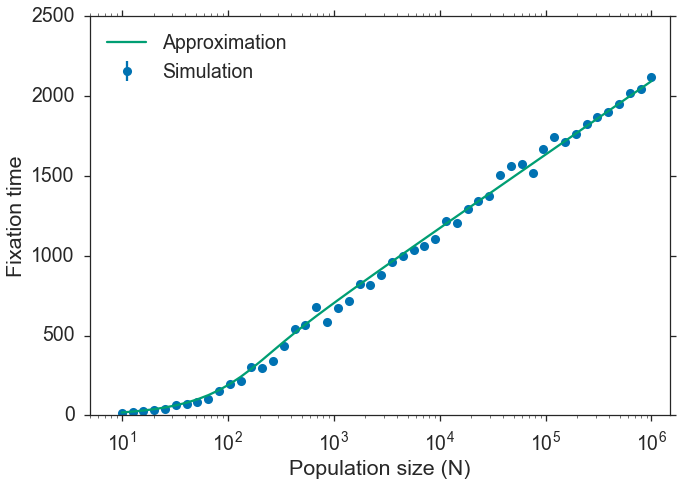

In [83]:
_ = np.array([fix_time_aggregate(res) for res in fix_time_sim])
fixation_time_mean = _[:,0]
fixation_time_sem  = _[:,1]

fig, ax = fixation_time_plot(Nrange, fixation_time_mean, fixation_time_sem)
ax.plot(Nrange, T_kimura(Nrange, s), label='Approximation')
ax.legend(loc=2);

# IPyWidgets

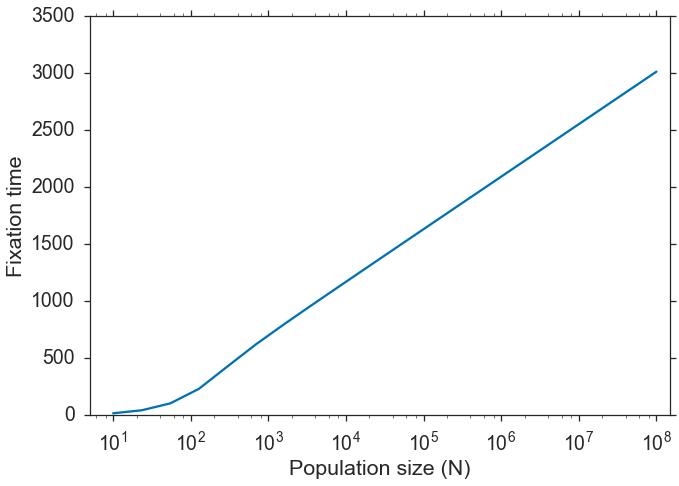

In [84]:
def approximation_plot(log10Nmax=6, log10s=-2):
    fig, ax = plt.subplots(1, 1)
    
    Nrange = np.logspace(1, log10Nmax, 1000)
    s = 10**log10s
    ax.plot(Nrange_kimura, T_kimura(Nrange_kimura, s))

    ax.set(
        xlabel='Population size (N)',
        ylabel='Fixation time',
        xscale='log', 
        xlim=(0.5 * Nrange_kimura.min(), 1.5 * Nrange_kimura.max()),
    )
            
approximation_plot();

In [85]:
import ipywidgets
print("IPyWidgets", ipywidgets.__version__)

IPyWidgets 4.1.1


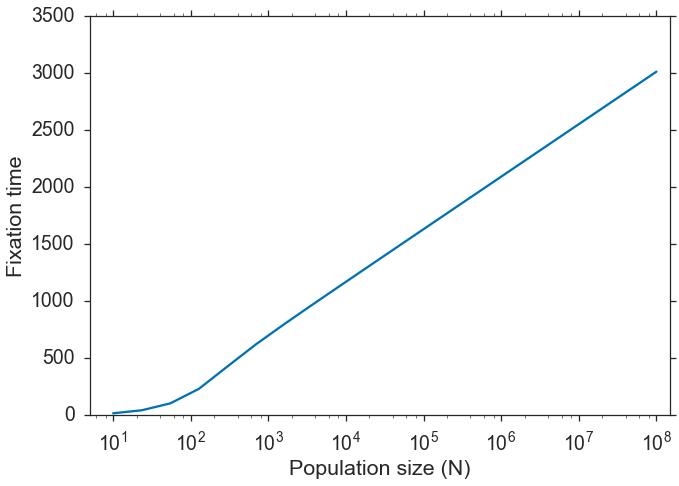

In [86]:
ipywidgets.interact(approximation_plot, log10Nmax=(1.0, 12.0), log10s=(-6.0, -1.0));

# Multi-type

In [87]:
def simulation(N, s, repetitions=1000):
    assert N > 0
    N = np.uint64(N)
    
    w = np.array([1, 1+s])
    S = np.diag(w)
    
    n = np.repeat([N - 1, 1], repetitions) 
    # rows are genotypes, cols are repretitions
    n = n.reshape((2, repetitions))
    # which columns to update
    update = np.array([True] * repetitions)

    while update.any():
        p = n/N  # counts to frequencies
        p = S @ p  # natural selection
        p /= p.sum(axis=0)  # mean fitness
        for j in update.nonzero()[0]:
            # random genetic drift
            n[:,j] = np.random.multinomial(N, p[:,j])
        update = (n[0,:] > 0) & (n[1,:] > 0) # neither genotype fixated

    return n[1] == N

fixation_prob = simulation(N=10000, s=0.1, repetitions=1000).mean()
print("% Fixation: {:.2g}".format(fixation_prob))

% Fixation: 0.17
